# Universidad Torcuato DiTella

# Financial Analytics

## TP Final

## Docente

Prof. Pablo Roccatagliata    --  proccatagliata@gmail.com 

## Autores
- Daniela Bessone            -- dsbessone@gmail.com          -- MiM
- Dan Frydman                -- frydmandan@gmail.com         -- MiM
- Rodrigo Corvalan Slaguero  -- rodrigocorvalan93@gmail.com  -- MFin
- Agustin Alba Chicar        -- ag.albachicar@gmail.com      -- MiM

## Repositorio

https://github.com/agalbachicar/fa_momentum

## Contenido

- [Analisis exploratorio del dataset](http://localhost:8888/notebooks/src/momentum.ipynb#1.--Realizar-un-an%C3%A1lisis-exploratorio-del-dataset.)
- [Ingenieria de features](http://localhost:8888/notebooks/src/momentum.ipynb#2.--Ingenieria-de-features)
  - [¿Encuentra valores de los features que parecen errores en los datos?](http://localhost:8888/notebooks/src/momentum.ipynb#2.1---%C2%BFNecesita-corregir-valores-faltantes?)
  - [¿Qué preprocesamiento necesitan las variables para los algoritmos de ensamble que va a utilizar?
](http://localhost:8888/notebooks/src/momentum.ipynb#2.2---%C2%BFQu%C3%A9-preprocesamiento-necesitan-las-variables-para-los-algoritmos-de-ensamble-que-va-a-utilizar?)
- [Metalabelling](http://localhost:8888/notebooks/src/momentum.ipynb#3.--Metalabelling)
  - [Momentum con medias de 50 y 200 dias](http://localhost:8888/notebooks/src/momentum.ipynb#3.1--Momentum-con-medias-de-50-y-200-dias)
  - [Predicciones](http://localhost:8888/notebooks/src/momentum.ipynb#3.2--Predicciones)
  - [Obtener el size del bet](http://localhost:8888/notebooks/momentum.ipynb#3.3--Obtener-el-size-del-bet)
  - [Optimizacion del Randon Forest](http://localhost:8888/notebooks/momentum.ipynb#3.5--Optimizacion-del-Random-Forest)
- [Diferenciación fraccionaria](http://localhost:8888/notebooks/momentum.ipynb#3.--Diferenciaci%C3%B3n-Fraccionaria)
  - [Necesidad de la diferenciación fraccionaria](http://localhost:8888/notebooks/momentum.ipynb#3.1--Necesidad-de-Diferenciaci%C3%B3n)
  - [Orden optimo de diferenciación](http://localhost:8888/notebooks/momentum.ipynb#3.2--Orden-%C3%93ptimo-de-Diferenciaci%C3%B3n)
- [Sample weights](http://localhost:8888/notebooks/momentum.ipynb#4--Sample-weights)
  - [¿Tiene sentido ponderar las observaciones?](http://localhost:8888/notebooks/momentum.ipynb#4.1--%C2%BFTiene-sentido-ponderar-las-observaciones?)
  - [¿Cuáles ponderadores utilizaría?](http://localhost:8888/notebooks/momentum.ipynb#4.2--%C2%BFCu%C3%A1les-ponderadores-utilizar%C3%ADa?)
  - [¿Por uniquess?](http://localhost:8888/notebooks/momentum.ipynb#4.3--%C2%BFPor-uniquess?)
  - [¿Por tamaño del retorno?](http://localhost:8888/notebooks/momentum.ipynb#4.4--%C2%BFPor-tama%C3%B1o-del-retorno?)
  - [¿Mejoran los resultados al ponderar?](http://localhost:8888/notebooks/momentum.ipynb#4.3--%C2%BFMejoran-los-resultados-al-ponderar?)

In [1]:
import datetime
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import time

from sklearn import datasets
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from scipy import interp

from itertools import cycle

In [2]:
# Constantes utiles.
DATA_FILE_PATH='mtum.csv'
RANDOM_STATE = 777
RUN_RANDOM_FOREST_OPTIMIZATION=False

# Model constants.
MIN_RET = .005
PT_SL=[2,1]
NUM_DAYS = 3
CLF_LAST_W = 0.75
FAST_EWMA_NUM_DAYS=3
SLOW_EWMA_NUM_DAYS=7
TEST_SIZE=0.5

In [3]:
def plot_mtum(df):
    '''
    Crea una figura con dos graficos en columna.
    El grafico de arriba imprime la evolucion del precio de cierre, maximo y minimo de forma diaria.
    El grafico de abajo imprime la evolucion del volumen operado en el dia.
    
    @param df Es el data frame de pandas de donde se extraen los valores.
              Espera que tenga cuatro series completas: 'Close','High', 'Low' y 'Date'.
       
    '''
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
    
    df.plot(kind='line',y='Close', x='Date', color='blue', ax=axes[0])
    df.plot(kind='line',y='High', x='Date', color='green', ax=axes[0])
    df.plot(kind='line',y='Low', x='Date', color='red', ax=axes[0])
    df.plot(kind='line',y='Open', x='Date', color='orange', ax=axes[0])
    plt.title('MTUM prices')

    df.plot(kind='line',y='Volume', x='Date', color='blue', ax=axes[1])
    plt.title('MTUM volume')

    plt.show()


### 1.- Realizar un análisis exploratorio del dataset. 


In [4]:
# Cargamos el data frame. La información puede conseguirse en:
# https://finance.yahoo.com/quote/MTUM/history?p=MTUM
mtum_df = pd.read_csv(DATA_FILE_PATH)
mtum_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-04-18,50.919998,50.919998,50.919998,50.919998,46.707516,400
1,2013-04-19,50.919998,50.919998,50.919998,50.919998,46.707516,0
2,2013-04-22,50.919998,50.919998,50.919998,50.919998,46.707516,0
3,2013-04-23,52.220001,52.220001,52.220001,52.220001,47.899956,600
4,2013-04-24,51.700001,51.700001,51.560001,51.560001,47.294567,1100


In [5]:
mtum_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1696,2020-01-13,127.809998,128.750000,127.809998,128.750000,128.750000,483400
1697,2020-01-14,128.750000,128.759995,128.259995,128.500000,128.500000,658000
1698,2020-01-15,128.619995,129.869995,128.580002,129.589996,129.589996,648200
1699,2020-01-16,130.080002,130.649994,129.899994,130.619995,130.619995,480900
1700,2020-01-17,130.860001,131.429993,130.699997,131.380005,131.380005,641600


In [6]:
# Evaluamos los tipos de dato presentes en el dataset.
mtum_df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
# Analizo si hay duplicados
duplicate_rows_df = mtum_df[mtum_df.duplicated()]
nrows, _ = duplicate_rows_df.shape
print('El dataframe posee {} duplicados.'.format(nrows))

El dataframe posee 0 duplicados.


In [8]:
# Analisis de valores nulos.
print(mtum_df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [9]:
# Descripcion por defecto del dataset provista por pandas.
mtum_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1.701000e+03
mean,84.316349,84.700094,83.843686,84.297155,81.107621,4.605891e+05
std,22.099439,22.221504,21.946565,22.094723,23.162624,6.649536e+05
min,50.070000,50.119999,49.709999,50.119999,45.973698,0.000000e+00
25%,67.800003,68.309998,67.300003,67.790001,63.558945,3.290000e+04
50%,76.260002,76.480003,75.949997,76.220001,72.951920,2.092000e+05
75%,107.150002,108.029999,106.209999,107.239998,105.039154,6.197000e+05
max,130.860001,131.429993,130.699997,131.380005,131.380005,6.123600e+06


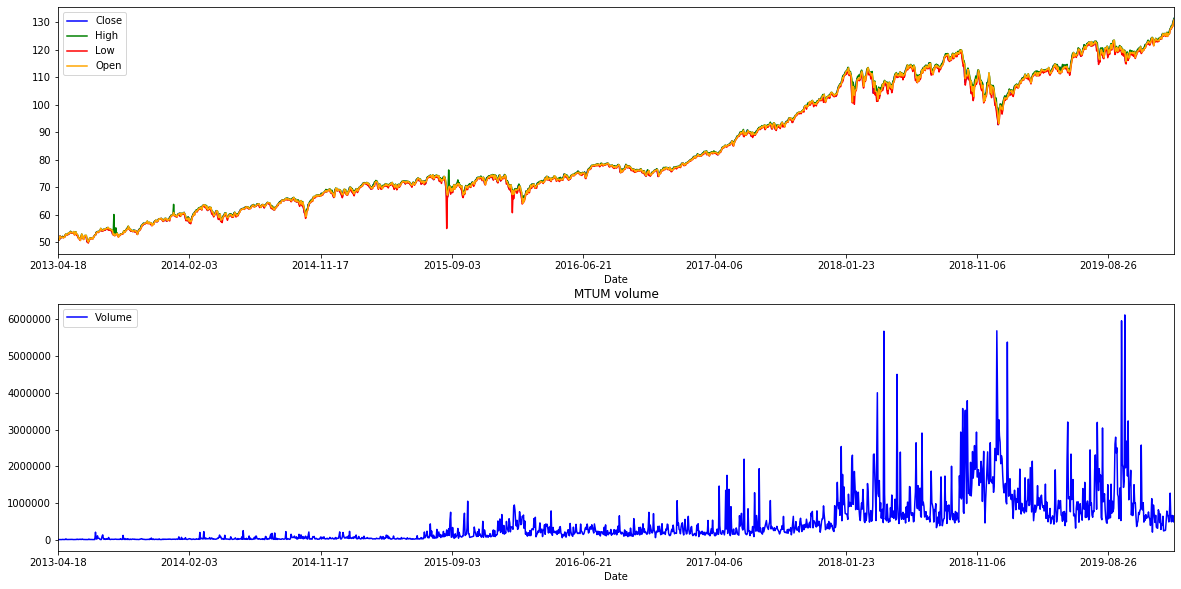

In [10]:
# Ploteamos el precio de cierre del ETF a lo largo de todo el tiempo.
plot_mtum(mtum_df)

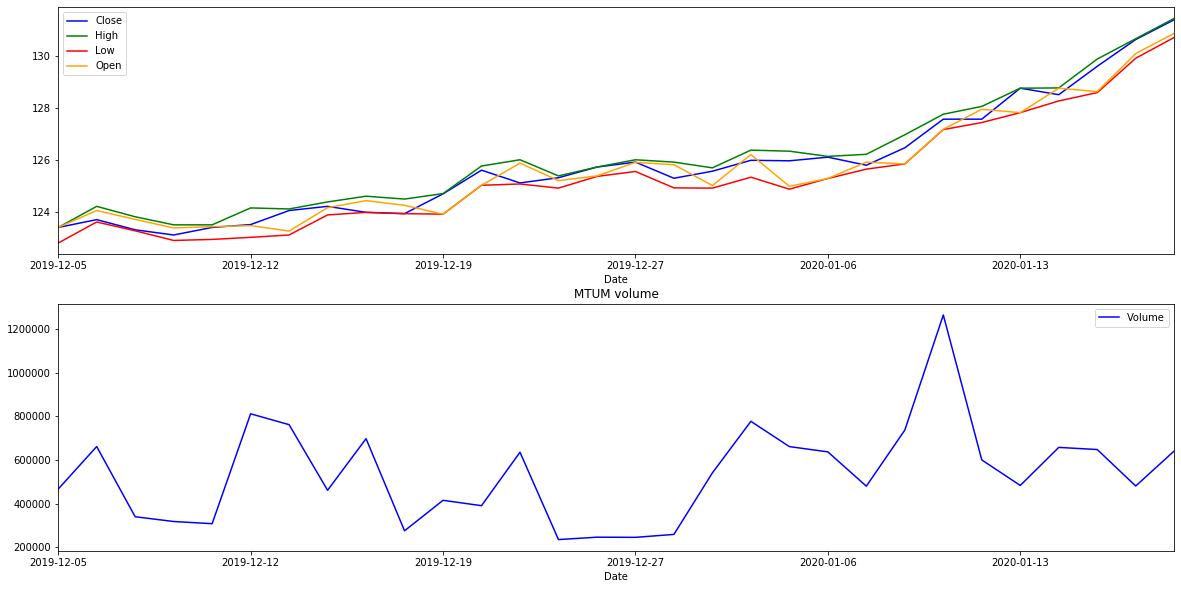

In [11]:
# Realizamos lo mismo pero para el ultimo mes.
plot_mtum(mtum_df.tail(30))

**Conclusiones**

El dataset mtum es un dataset de serie temporal diaria que contiene los precios de apertura, cierre, maximo y minimo además del volumen operado de iShares Edge MSCI USA Momentum Factor ETF (ver https://www.blackrock.com/cl/productos/251614/ishares-msci-usa-momentum-factor-etf).

El dataset no posee NA / missing data y contine aproximadamente 1700 registros, que son el resultado del registro diario desde el 18 de abril de 2013 al 13 de enero de 2020 (con la excepcion de los dias en que el ETF no opero - feriados, fines de semana, etc.).

### 2.- Ingenieria de features

#### 2.1 - ¿Necesita corregir valores faltantes?

In [12]:
# Detalle de las fechas faltantes
dates_df = mtum_df[['Date']].copy()
dates_df.Date = pd.to_datetime(dates_df['Date'], infer_datetime_format=True)
dates_df['DayOfWeek'] = dates_df.Date.dt.dayofweek
# Evaluamos si hay sabados y domingos
dates_df.loc[dates_df['DayOfWeek'].isin([5, 6])].shape

(0, 2)

In [13]:
# Buscamos el 4 de julio (feriados en USA). Para ejemplificar, el 4/7/2019 fue jueves.
dates_df.loc[dates_df['Date'] == datetime.date(year=2019, month=7, day=4)].shape

/home/agustin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  


(0, 2)

**Conclusion**

Los dias que estan, estan porque son los que el ETF opero. No se requiere corregir errores por valores faltantes.

#### 2.2 - ¿Qué preprocesamiento necesitan las variables para los algoritmos de ensamble que va a utilizar? 

Referencias:
- https://towardsdatascience.com/financial-machine-learning-part-0-bars-745897d4e4ba
- Advances in Financial Machine Learning, seccion: 2.3
- https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Tick%2C%20Volume%2C%20Dollar%20Volume%20Bars.ipynb

Evaluamos la ocurrencia de outliers en la serie, con el fin de remover las entradas. Outliers en estos casos serán valores que no tienen razon de ser en el dataset.

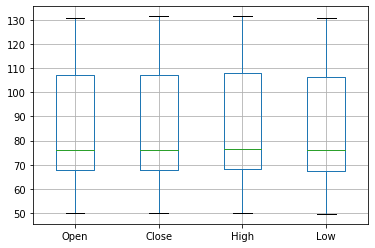

In [14]:
mtum_df.boxplot(['Open', 'Close', 'High', 'Low'])

En el grafico anterior se puede ver que no existen valores extremos imposibles.

##### Bars

**Tick bars**

No tiene sentido operar con tick bars y esta serie debido a que los tick bars cuentan el numero de operaciones realizadas. El dataset del ETF solo muestra la variacion de precios del ETF con granularidad diaria.

**Volume bars**

La generación de bars por volumen operado se adjunta a continuacion.

**Dollar bars**

La generación de bars por volumen monetizado de operación se adjunta a continuacion.

**Dollar / Volume imbalance bars**

La generación de bars por volumen o volumen monetizado imbalanceado se adjunta a continuación. A saber, los algoritmos son los mismos para ambos bars, solo cambia la serie (volumen o volumen monetizado).

In [15]:
def tick_bars(df, price_column, m):
    '''
    compute tick bars

    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def tick_bar_df(df, price_column, m):
    '''
    Filtra `df` por los tick_bars 
    '''
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx].drop_duplicates()

#-------------------------------------------------
def volume_bars(df, volume_column, m):
    '''
    compute volume bars

    # args
        df: pd.DataFrame()
        volume_column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx].drop_duplicates()

#-------------------------------------------------
def create_dollar_volume_series(df, price_col, volume_col):
    return df[price_col] * df[volume_col]

def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars

    # args
        df: pd.DataFrame()
        dv_column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx].drop_duplicates()

#-------------------------------------------------
def tick_direction(prices):
    '''
    Computa un vector de ticks {1, -1} cuyo signo indica el valor
    del retorno entre dos muestras consecutivas.
    El valor inicial es el mismo que el primero computado.
    El vector de retorno tiene el mismo tamaño que @p prices.
    
    @param prices Es un vector de precios a diferenciar y obtener el signo del retorno.
    @return b_t, un vector de tick imbalance bars.
    '''
    tick_directions = prices.diff()
    tick_directions[0] = tick_directions[1]
    tick_directions = tick_directions.transform(lambda x: np.sign(x))
    return tick_directions

def signed_volume(tick_directions, volumes):
    '''
    Computa una serie de volumenes signados segun el computo de ticks.
    
    @param tick_directions La serie con el signo de del retorno.
    @param volumes La serie de volumenes para cada sample temporal de retorno.
    @return Una serie de volumenes signados, o bien el producto elemento a elemento de
            @p tick_directions con @p volumes.
    '''
    return tick_directions.multiply(volumes)

def exponential_weighted_moving_average(arr_in, window):
    '''
    @see https://stackoverflow.com/a/51392341
    
    Exponentialy weighted moving average specified by a decay ``window``
    assuming infinite history via the recursive form:

        (2) (i)  y[0] = x[0]; and
            (ii) y[t] = a*x[t] + (1-a)*y[t-1] for t>0.

    This method is less accurate that ``_ewma`` but
    much faster:

        In [1]: import numpy as np, bars
           ...: arr = np.random.random(100000)
           ...: %timeit bars._ewma(arr, 10)
           ...: %timeit bars._ewma_infinite_hist(arr, 10)
        3.74 ms ± 60.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
        262 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

    Parameters
    ----------
    arr_in : np.ndarray, float64
        A single dimenisional numpy array
    window : int64
        The decay window, or 'span'

    Returns
    -------
    np.ndarray
        The EWMA vector, same length / shape as ``arr_in``

    Examples
    --------
    >>> import pandas as pd
    >>> a = np.arange(5, dtype=float)
    >>> exp = pd.DataFrame(a).ewm(span=10, adjust=False).mean()
    >>> np.array_equal(_ewma_infinite_hist(a, 10), exp.values.ravel())
    True
    '''
    n = arr_in.shape[0]
    ewma = np.empty(n, dtype=float)
    alpha = 2 / float(window + 1)
    ewma[0] = arr_in[0]
    for i in range(1, n):
        ewma[i] = arr_in[i] * alpha + ewma[i-1] * (1 - alpha)
    return ewma

def compute_initial_e_v(signed_volumes):
    '''
    Computa el valor absoluto de la media de los volumenes signados.
    Sirve como estimacion del valor inicial de Φ_T para toda la serie de volumenes.
    '''
    return abs(signed_volumes.mean())

def compute_tick_imbalance(signed_volumes, e_t_0, abs_e_v_0):
    '''
    @param signed_volumes Serie de volumenes signados.
    @param e_t_0 El valor inicial de la $E(T)$
    @param abs_e_v_0 El valor absoluto del valor medio (hint) de $Φ_T$.
    @return Una tupla {Ts, abs_thetas, thresholds, i_s} donde:
        Ts: es un vector con los valores de $T$ que se tomaron como largo de ventana de EWMA.
        abs_thetas: es un vector que indica los valores de Φ_T para cada valor de volumen.
        thresholds: es un vector que indica el valor the umbrales que se como para cada valor de volumen.
        i_s: es un vector con los valores de los indices que referencia al vector de volumen con un cambio de tick.
    '''
    Ts, i_s = [], []
    
    # Valores de la iteracion
    # i_prev: valor de indice previo donde se fijo $T$.
    # e_t: $E(T)$ iteracion a iteracion.
    # abs_e_v: $|Φ_T|$ iteracion a iteracion.
    i_prev, e_t, abs_e_v  = 0, e_t_0, abs_e_v_0
    
    n = signed_volumes.shape[0]
    signed_volumes_val = signed_volumes.values.astype(np.float64)
    abs_thetas, thresholds = np.zeros(n), np.zeros(n)
    abs_thetas[0], cur_theta = np.abs(signed_volumes_val[0]), signed_volumes_val[0]
    for i in range(1, n):
        cur_theta += signed_volumes_val[i]
        abs_theta = np.abs(cur_theta)
        abs_thetas[i] = abs_theta
        
        threshold = e_t * abs_e_v
        thresholds[i] = threshold
        
        if abs_theta >= threshold:
            cur_theta = 0
            Ts.append(np.float64(i - i_prev))
            i_s.append(i)
            i_prev = i
            e_t = exponential_weighted_moving_average(np.array(Ts), window=np.int64(len(Ts)))[-1]
            abs_e_v = np.abs(exponential_weighted_moving_average(signed_volumes_val[:i], window=np.int64(e_t_0 * 3))[-1] ) # window of 3 bars
    return Ts, abs_thetas, thresholds, i_s

/home/agustin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


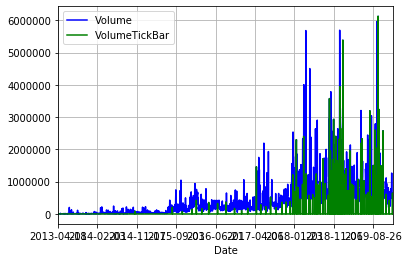

In [16]:
# Genero una serie con los valores del bar de volumenes. El valor de seleccion
# de volumen de corte es arbitrario, simplemente para ejemplificar la de generacion y visualizacion.
t = 20 * mtum_df.Volume.mean() # Valor arbitrario
mtum_df['VolumeTickBar'] = 0

idx = volume_bars(mtum_df, 'Volume', t)
mtum_df.VolumeTickBar.iloc[idx] = mtum_df.Volume.iloc[idx]

ax = mtum_df.plot(kind='line', y='Volume', x='Date', color='blue')
mtum_df.plot(kind='line', y='VolumeTickBar', x='Date', color='green', ax=ax)
plt.grid()
plt.show()

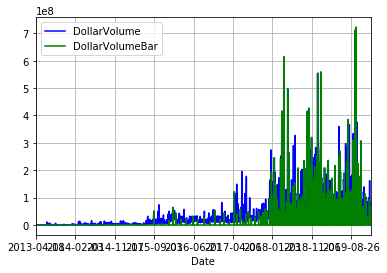

In [17]:
mtum_df['DollarVolume'] = create_dollar_volume_series(mtum_df, 'Close', 'Volume')

# Genero una serie con los valores del bar de volumenes dolarizados. El valor de seleccion
# de corte es arbitrario, simplemente para ejemplificar la de generacion y visualizacion.
t = 10 * mtum_df.DollarVolume.mean() # Valor arbitrario
mtum_df['DollarVolumeBar'] = 0

idx = dollar_bars(mtum_df, 'DollarVolume', t)
mtum_df.DollarVolumeBar.iloc[idx] = mtum_df.DollarVolume.iloc[idx]

ax = mtum_df.plot(kind='line', y='DollarVolume', x='Date', color='blue')
mtum_df.plot(kind='line', y='DollarVolumeBar', x='Date', color='green', ax=ax)
plt.grid()
plt.show()

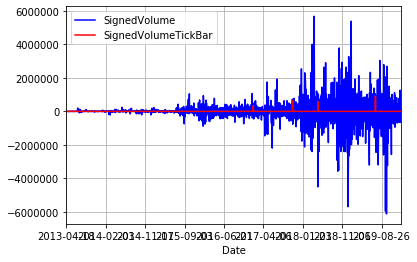

In [18]:
# Genero una nueva serie, el volumen signado por variacion de precio.
mtum_df['SignedVolume'] = signed_volume(tick_direction(mtum_df.Close), mtum_df.Volume)
mtum_df['SignedVolumeTickBar'] = 0

e_t_0 = 200 # Arbitrario
Ts, abs_thetas, thresholds, i_s = compute_tick_imbalance(mtum_df.SignedVolume, e_t_0, compute_initial_e_v(mtum_df.SignedVolume))
mtum_df.SignedVolumeTickBar.iloc[i_s] = mtum_df.SignedVolume.iloc[i_s]

# Mostramos los ticks imbalance volume dollar bars.
ax = mtum_df.plot(kind='line',y='SignedVolume', x='Date', color='blue')
ax = mtum_df.plot(kind='line',y='SignedVolumeTickBar', x='Date', color='red', ax = ax)
plt.grid()
plt.show()

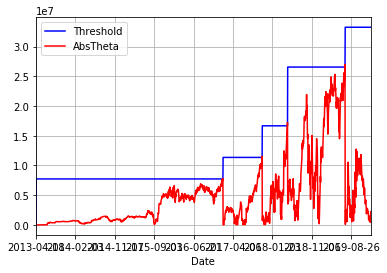

In [19]:
# Genero un data frame para plotear y mostrar la evolucion del threshold y la evolucion del volumen agregado.
# Cada cambio de threshold se relaciona con un tick en VIB.
tib_df = mtum_df[['Date']].copy()
tib_df['Threshold'] = thresholds
tib_df['AbsTheta'] = abs_thetas

ax = tib_df.plot(kind='line', y='Threshold', x='Date', color='blue')
tib_df.plot(kind='line',y='AbsTheta', x='Date', color='red', ax=ax)
plt.grid()
plt.show()

### 3.- Metalabelling

#### 3.1- Momentum con medias de 50 y 200 dias

Existen muchas formas de implementar momentum, una de estas es con los cruces entre las medias de 50 y 200 días como en el ejercicio
[3.4 del López de Prado](https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Labeling%20and%20MetaLabeling%20for%20Supervised%20Classification.ipynb). 

In [20]:
def compute_ewma(prices, window_size):
    '''
    Computes the EWMA of a price series with a certain window size.
    
    @param prices A pandas series.
    @param window_size EWMA window size.
    @return The EWMA with `window_size` window size of `prices`.
    '''
    return prices.ewm(window_size).mean()

def get_up_cross(fast_ewma, slow_ewma):
    '''
    Computes the fast EWMA serie cross over the slow EWMA serie.
    
    @param fast_ewma A fast EWMA pandas series.
    @param slow_ewma A slow EWMA pandas series.
    @return A filtered version of `fast_ewma` that indicates when the buy trend starts.
    '''
    crit1 = fast_ewma.shift(1) < slow_ewma.shift(1)
    crit2 = fast_ewma > slow_ewma
    return fast_ewma[(crit1) & (crit2)]

def get_down_cross(fast_ewma, slow_ewma):
    '''
    Computes the slow EWMA serie cross over the fast EWMA serie.
    
    @param fast_ewma A fast EWMA pandas series.
    @param slow_ewma A slow EWMA pandas series.
    @return A filtered version of `fast_ewma` that indicates when the sell trend starts.
    '''
    crit1 = fast_ewma.shift(1) > slow_ewma.shift(1)
    crit2 = fast_ewma < slow_ewma
    return fast_ewma[(crit1) & (crit2)]

def create_bet_signal_fast_slow_ewma(df, price_column, fast_window_size, slow_window_size):
    '''
    Computes the buy / sell events based on the 50-200 EWMA cross.
    
    Appends three series to `df`:
    1- FastEWMA : the fast EWMA computed with `fast_window_size`.
    2- SlowEWMA : the fast EWMA computed with `slow_window_size`.
    3- BetEWMA : an integer series with {1, 0, -1} values meaning {Buy, Do nothing, Sell}.
    
    @param df A pandas data frame to extract the price series from.
    @param price_column A string telling the name of the price series.
    @param fast_window_size The fast EWMA window size.
    @param slow_window_size The slow EWMA window size.
    @return `df` with the appended columns.
    '''
    fast_ewma = compute_ewma(df[price_column], fast_window_size)
    slow_ewma = compute_ewma(df[price_column], slow_window_size)
    buy_bet = get_up_cross(fast_ewma, slow_ewma)
    sell_bet = get_down_cross(fast_ewma, slow_ewma)
    
    df['FastEWMA'] = fast_ewma
    df['SlowEWMA'] = slow_ewma
    df['BetEWMA'] = 0
    df.BetEWMA.iloc[buy_bet.index] = 1
    df.BetEWMA.iloc[sell_bet.index] = -1
    return df

In [21]:
def plot_ewma_bet_signals(df):
    f, ax = plt.subplots(figsize=(20,10))

    df.plot(ax=ax, alpha=.5, y='Close', x='Date', color='blue')
    df.plot(ax=ax, alpha=.5, y='FastEWMA', x='Date', color='yellow')
    df.plot(ax=ax, alpha=.5, y='SlowEWMA', x='Date', color='brown')
    df.Close.loc[df.BetEWMA == 1].plot(ax=ax, ls='', marker='^', markersize=7, alpha=0.75, label='Buy', color='green')
    df.Close.loc[df.BetEWMA == -1].plot(ax=ax, ls='', marker='v', markersize=7, alpha=0.75, label='Sell', color='red')
    ax.grid()
    ax.legend()

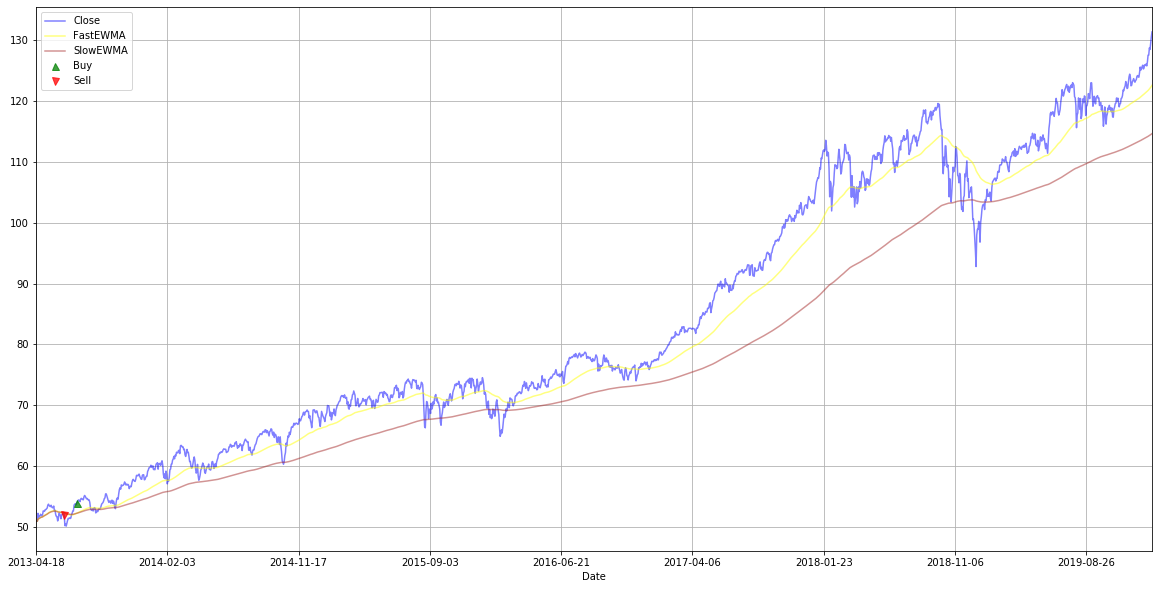

In [22]:
mtum_df = create_bet_signal_fast_slow_ewma(mtum_df, 'Close', 50, 200)
plot_ewma_bet_signals(mtum_df)

Es importante notar que solo se produjeron una señal de venta y otra de compra. Como se sabe, los valores de ventanas temporales no fueron aprendidos, por lo que a modo de ejemplificar se muestran algunas graficas de progresiones mas rapidas en ambas ventanas.

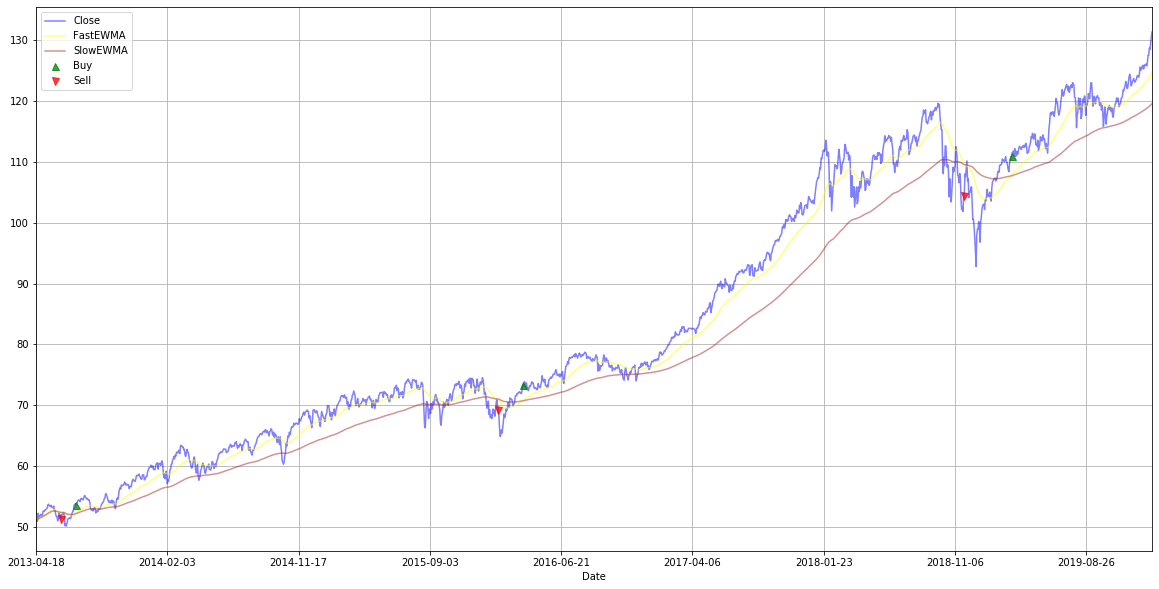

In [23]:
mtum_df = create_bet_signal_fast_slow_ewma(mtum_df, 'Close', 25, 100)
plot_ewma_bet_signals(mtum_df)

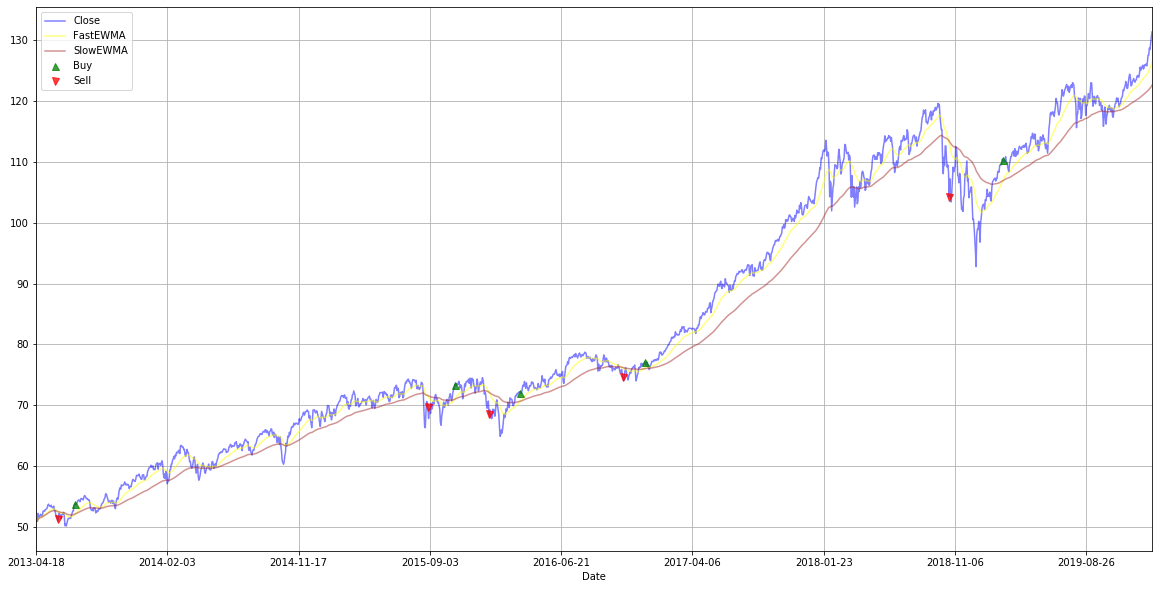

In [24]:
mtum_df = create_bet_signal_fast_slow_ewma(mtum_df, 'Close', 14, 50)
plot_ewma_bet_signals(mtum_df)

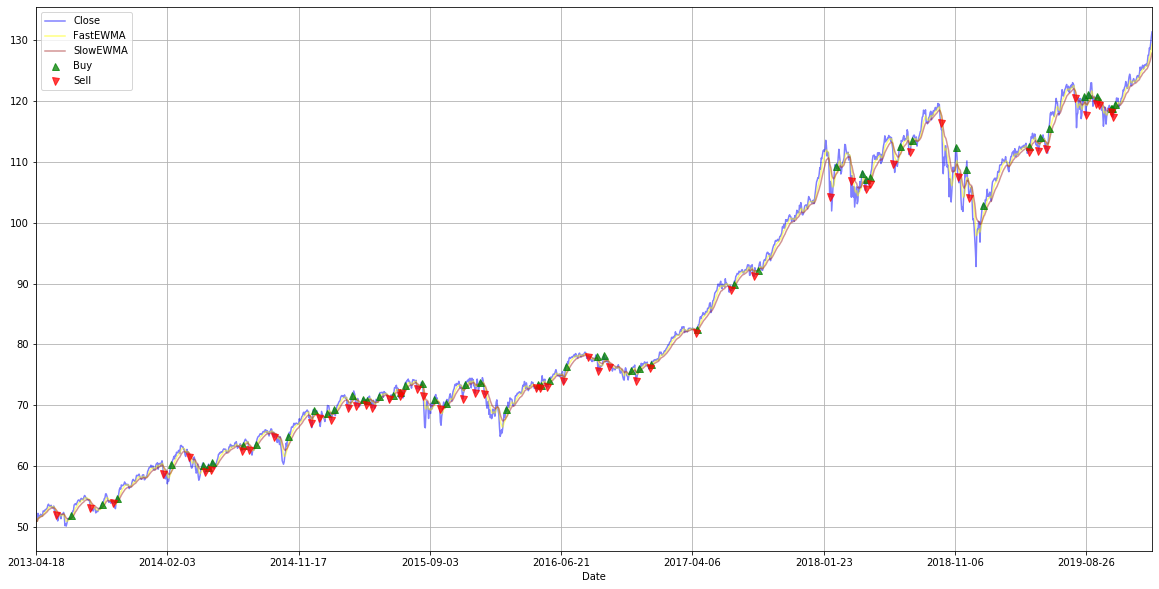

In [25]:
mtum_df = create_bet_signal_fast_slow_ewma(mtum_df, 'Close', 3, 7)
plot_ewma_bet_signals(mtum_df)

#### 3.2- Predicciones

Una vez obtenido el side del bet sobre el ETF MTUM en base a los cruces de las medias móviles puede armar el label a predecir usando los snippets 3.6 y 3.7 del López de Prado. 

In [26]:
def getDailyVol(close,span0=100):
    '''
    Computes the daily volatility of price returns.
    It takes a closing price series, applies a diff sample to sample
    (assumes each sample is the closing price), computes an EWM with 
    `span0` samples and then the standard deviation of it.
    
    @param[in] close A series of prices where each value is the closing price of an asset.
    @param[in] span0 The sample size of the EWM.
    @return A pandas series of daily return volatility.
    '''
    df0=close.diff()
    df0=df0 - 1
    df0[0]=0
    df0=df0.ewm(span=100).std().rename('dailyVol')
    df0[0]=df0[1]
    return df0

def getTEvents(close, h):
    '''
    Computes a pandas series of indices of `df[price_col]` that are the output
    of a CUSUM positive and negative filter. The threshold of the filter is `h`.
    
    @param[in] close A series of prices where each value is the closing price of an asset.
    @param[in] h CUSUM filter threshold.
    @return A pandas index series that mark where the CUSUM filter flagged either positive
    and negative cumulative sums that are bigger than `h`.
    '''
    tEvents, sPos, sNeg = [], 0, 0
    diff = close.diff()
    diff[0] = 0
    for i in diff.index:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        if sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.Int64Index(tEvents)
    

def addVerticalBarrier(tEvents, close, numDays=1):
    '''
    Returns a filtered pandas series of prices coming from `close` that
    belong to the offset price in `numDays` of `tEvents` prices.
    
    @param[in] tEvents A pandas index series that match the same type of `close`'s index.
    @param[in] close A series of prices where each value is the closing price of an asset.
    @param[in] numDays A delta in samples to apply to all a vertical barrier.
    @return A pandas series of prices. 
    '''
    t1=close.index.searchsorted(tEvents + numDays)
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

def applyPtSlOnT1(close,events,ptSl,molecule):
    '''
    Apply stop loss/profit taking, if it takes place before t1 (end of event)
    
    @param[in] close A pandas series of prices.
    @param[in] events A pandas dataframe, with columns:
      - `t1`:  the timestamp of vertical barries. When the value is np.nan, there will not be a vertical barrier.
      - `trgt`: the unit width of the horizontal barriers.
    @param[in] ptSl A list of two non-negative float values:
      - `ptSl[0]`: the factor that multiplies `trgt` to set the width of the upper barrier. If 0, there will not be an upper barrier.
      - `ptSl[1]`: the factor that multiplies `trgt` to set the width of the lower barrier. If 0, there will not be an lower barrier.
    @param[in] molecule  A list with the subset of event indices that will be processed by a single thread.
    '''
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        loc = int(loc)
        t1 = int(t1)
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=applyPtSlOnT1(close, events, ptSl_, events.index)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events
    
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

def getBinsNew(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    
    if 'side' not in events_:
        # only applies when not meta-labeling
        # to update bin to 0 when vertical barrier is touched, we need the original
        # vertical barrier series since the events['t1'] is the time of first 
        # touch of any barrier and not the vertical barrier specifically. 
        # The index of the intersection of the vertical barrier values and the 
        # events['t1'] values indicate which bin labels needs to be turned to 0
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.
    
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

In [27]:
fast_ewma = compute_ewma(mtum_df.Close, FAST_EWMA_NUM_DAYS)
slow_ewma = compute_ewma(mtum_df.Close, SLOW_EWMA_NUM_DAYS)
up = get_up_cross(fast_ewma, slow_ewma)
down = get_down_cross(fast_ewma, slow_ewma)
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()

In [28]:
dailyVol = getDailyVol(mtum_df.Close)
tEvents = getTEvents(mtum_df.Close, h=dailyVol.mean())
t1 = addVerticalBarrier(tEvents, mtum_df.Close, numDays=NUM_DAYS)
target=dailyVol

events = getEvents(mtum_df.Close, tEvents, PT_SL, target, MIN_RET, t1=t1, side=side)
events_side = events.dropna().side
labels = getBinsNew(events, mtum_df.Close, t1).dropna()

Xx = pd.merge_asof(labels, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')
Xx

/home/agustin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,ret,bin,side
54,0.012900,1.0,1
83,0.001508,1.0,-1
124,0.025018,1.0,1
194,0.013295,1.0,-1
206,0.014264,1.0,1
...,...,...,...
1614,-0.011292,0.0,-1
1620,0.006288,1.0,-1
1638,0.007695,1.0,-1
1640,-0.013713,0.0,-1


#### 3.3- Obtener el size del bet

Una vez obtenidos los labels entrene un random forest para obtener el size. La sección 10.3 Bet Sizing from Predicted Probabilities del Lopez de Prado le será muy útil. La idea es que el size óptimo estará dado
por la probabilidad estimada de target=1 (no dejar pasar la oportunidad).

In [29]:
def getRandomForest():
    n_estimator = 10000
    rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator, criterion='entropy', random_state=RANDOM_STATE)
    return rf

def plotROC(y_test, y_pred_rf):
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [30]:
def train_test_samples(events, labels, test_size, binarize = False):
    X = events_side.dropna().values.reshape(-1,1)
    y = labels.bin.values
    if binarize: y = label_binarize(y, [-1, 0, 1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    return X, y, X_train, X_test, y_train, y_test

In [31]:
X, y, X_train, X_test, y_train, y_test = train_test_samples(events, labels, TEST_SIZE)

              precision    recall  f1-score   support

         0.0       0.59      0.62      0.61        16
         1.0       0.60      0.56      0.58        16

    accuracy                           0.59        32
   macro avg       0.59      0.59      0.59        32
weighted avg       0.59      0.59      0.59        32



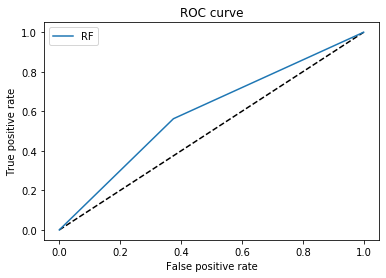

In [32]:
rf = getRandomForest()
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
plotROC(y_test, y_pred)

In [33]:
from scipy.stats import norm

def getSignal(events, stepSize, prob, pred, numClasses, **kargs):
    if prob.shape[0] == 0: return pd.Series()
    signal0 = (prob - 1. / numClasses) / (prob * (1. - prob)) ** 0.5
    signal0 = pred * (2. * norm.cdf(signal0) - 1.)
    return signal0
    # if 'side' in events: signal0*=events.loc[signal0.index, 'side']
    # df0 = signal0.to_frame('signal').join(events[['t1']], how='left')
    # df0 = avgActiveSignals(df0)
    # signal1 = discreteSignal(signal0=pd.Series(signal0), stepSize=stepSize)
    # return signal1

def avgActiveSignals(signals):
    tPnts = set(signals['t1'].dropna().values)
    tPnts = tPnts.union(signals.index.values)
    tPnts = list(tPnts); tPnts.sort()
    out = mpAvgActiveSignals(signals, ('molecule', tPnts))
    return out

def mpAvgActiveSignals(signals, molecule):
    out = pd.Series()
    for loc in molecule:
        df0 = (signals.index.values <= loc) & ((loc < signals['t1']) | pd.isnull(signals['t1']))
        act = signals[df0].index
        if len(act) > 0: out[loc] = signals.loc[act, 'signal'].mean()
        else: out[loc] = 0
    return out

def discreteSignal(signal0, stepSize):
    signal1 = (signal0 / stepSize).round() * stepSize
    signal1[signal1 > 1] = 1
    signal1[signal1 < 1] = -1
    return signal1

In [34]:
getSignal(X, 0.1, y_pred_rf, y_pred, 2.)

array([ 0.39787896, -0.        ,  0.39787896, -0.        , -0.        ,
       -0.        ,  0.39787896, -0.        , -0.        ,  0.39787896,
       -0.        , -0.        ,  0.39787896,  0.39787896,  0.39787896,
       -0.        , -0.        ,  0.39787896,  0.39787896, -0.        ,
        0.39787896, -0.        ,  0.39787896,  0.39787896,  0.39787896,
       -0.        ,  0.39787896, -0.        , -0.        , -0.        ,
       -0.        ,  0.39787896])

#### 3.5- Optimizacion del Random Forest

Recuerde hacer la optimización de hiper parámetros del random forest
tales como la profundidad máxima de cada árbol.

https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead


In [35]:
def getOptimizedRandomForest():
    n_estimators = [5000, 10000, 15000]
    max_depth = [2, 3, 4,]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_lead = [1, 2, 5,]

    grid_params = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_lead}
    if RUN_RANDOM_FOREST_OPTIMIZATION:
        random_forest_classifier = RandomForestClassifier(random_state=RANDOM_STATE)
        rf = RandomizedSearchCV(estimator = random_forest_classifier, param_distributions=grid_params, n_iter=500, cv=5, verbose=2, random_state=RANDOM_STATE**2, n_jobs=-1)
        return rf
    return getRandomForest()

              precision    recall  f1-score   support

         0.0       0.59      0.62      0.61        16
         1.0       0.60      0.56      0.58        16

    accuracy                           0.59        32
   macro avg       0.59      0.59      0.59        32
weighted avg       0.59      0.59      0.59        32



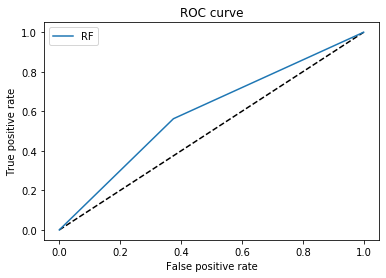

In [36]:
rf = getOptimizedRandomForest()
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
plotROC(y_test, y_pred)

### 3.- Diferenciación Fraccionaria

#### 3.1- Necesidad de Diferenciación

Toda serie que se busca transformar en estacionaria debería diferenciarse fraccionariamente. De esta forma, puede alcanzarse una transformación que cumpla los requisitos de estacionaridad, con la menor pérdida de memoria posible, lo que permite la aplicación conservar su poder predictivo para la posterior aplicación de algoritmos de ML. La única excepción a esta regla es el caso de las series cointegradas.

In [37]:
def getWeights(d,size):
    # thres>0 drops insignificant weights
    w=[1.]
    for k in range(1,size):
        w_=-w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

def plotWeights(dRange,nPlots,size):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0],dRange[1],nPlots):
        w_=getWeights(d,size=size)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
        w=w.join(w_,how='outer')
    ax=w.plot()
    ax.legend(loc='upper left');mpl.show()
    return

def plotWeights_FFD(dRange,nPlots,thres):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0],dRange[1],nPlots):
        w_=getWeights_FFD(d,thres=thres)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
        w=w.join(w_,how='outer')
    ax=w.plot()
    ax.legend(loc='upper left');mpl.show()
    return

def getWeights_FFD(d, thres):
    w, k = [1.0], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)


def fracDiff_FFD(series, d, thres=1e-5):
    # Constant width window (new solution)
    #Note 1: thres determines the cut-off weight for the window
    #Note 2: d can be any positive fractional, not necessarily bounded [0,1]
    
    #1) Compute weights for the longest series
    w =  getWeights_FFD(d, thres)
    width, df = len(w) - 1, {}
    
    #2) Apply weights to values
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series(index=series.index)
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

def plotMinFFD(close, threshold, testMinFFDFileName = None):
    from statsmodels.tsa.stattools import adfuller
    out= pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0= close
    for d in np.linspace(0,1,21):
        df1=np.log(df0).resample('1D').last().dropna() # downcast to daily obs. Dropped NAs
        df2=fracDiff_FFD(df1, d, thres=threshold).dropna()
        corr=np.corrcoef(df1.loc[df2.index,'Close'],df2['Close'])[0,1]
        df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    if testMinFFDFileName is not None: out.to_csv(testMinFFDFileName)
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    mpl.pyplot.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    #mpl.savefig(path+instName+'_testMinFFD.png')
    return out

#### 3.2- Orden Óptimo de Diferenciación
Se recomienda un orden de diferenciación fraccionaria d = 0.5 ya que es aquel valor que hace que la serie tenga la menor pérdida de memoria posible, sin comprometer el requerimiento de estacionaridad. (A un nivel de confianza del 95%, el valor crítico del estadístico ADF = -2.863). Vemos en la figura (y en los resultados _testMinFFD), que ese valor de de estadístico se alcanza para un 0.4 < d < 0.5. (Cruzes línea punteada y azul).

Validamos a su vez la recomendación de diferenciar fraccionariamente la serie, ya que 0< d* << 1, lo que implica que en caso de no haber diferenciado la misma, se habría perdido mucha memoria.

Finalmente, se observa también que para dicho punto, la correlación entre la serie original (d=0) y la diferenciada es alta, lo cual confirma que el procedimiento fue exitoso en alcanzar la estacionalidad sin un alto sacrificio de memoria.

,adfStat,pVal,lags,nObs,95% conf,corr
0.00,-0.686522,8.502098e-01,1.0,1699.0,-2.863243,1.000000
0.05,-0.667179,8.550688e-01,1.0,1695.0,-2.863247,0.999990
0.10,-0.781125,8.246038e-01,1.0,1692.0,-2.863250,0.999914
0.15,-0.913525,7.834857e-01,1.0,1690.0,-2.863252,0.999703
0.20,-1.037721,7.392589e-01,1.0,1689.0,-2.863253,0.999303
0.25,-1.277085,6.395897e-01,1.0,1688.0,-2.863254,0.998558
0.30,-1.530640,5.183035e-01,1.0,1688.0,-2.863254,0.997484
0.35,-1.846766,3.575029e-01,1.0,1688.0,-2.863254,0.995787
0.40,-2.142385,2.278164e-01,1.0,1689.0,-2.863253,0.993848
0.45,-2.616126,8.970985e-02,1.0,1689.0,-2.863253,0.990115


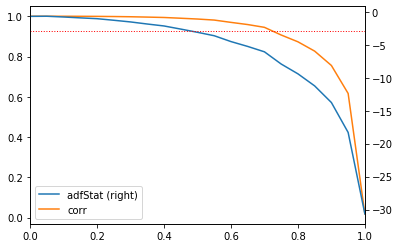

In [38]:
threshold = 0.01
pValue = 0.05

close_df = mtum_df.filter(['Close'], axis= 1)
close_df.index = mtum_df['Date'].astype('datetime64[ns]')

minFFD = plotMinFFD(close_df, threshold)
minFFD

In [39]:
d = abs(minFFD['pVal'] - pValue).idxmin()
d

0.5

In [40]:
fracDiff = fracDiff_FFD(series=close_df[['Close']], d=d, thres=5e-5)
fracDiff.index = mtum_df.index

In [41]:
# Obtains the crossing events of the 3-7 EWMA curves.
fast_ewma = compute_ewma(fracDiff.Close, FAST_EWMA_NUM_DAYS)
slow_ewma = compute_ewma(fracDiff.Close, SLOW_EWMA_NUM_DAYS)

up = get_up_cross(fast_ewma, slow_ewma)
down = get_down_cross(fast_ewma, slow_ewma)

side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()

In [42]:
# Gets the daily volatility of prices to serve events as a threshold.
dailyVol = getDailyVol(fracDiff.Close)
tEvents = getTEvents(fracDiff.Close, h=dailyVol.mean())
# Gets the vertical barrier events.
t1 = addVerticalBarrier(tEvents, fracDiff.Close, numDays=NUM_DAYS)
target=dailyVol
# Computes the events.
events = getEvents(fracDiff.Close, tEvents, PT_SL, target, MIN_RET, t1=t1, side=side)
events_side = events.dropna().side
# Gets the labels for the events.
labels = getBinsNew(events, fracDiff.Close, t1).dropna()
Xx = pd.merge_asof(labels, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')
Xx

/home/agustin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,ret,bin,side
351,0.052477,1.0,-1
360,-0.443788,0.0,-1
381,-0.051850,0.0,1
401,-0.112910,0.0,1
422,-0.389546,0.0,1
...,...,...,...
1668,-0.416359,0.0,-1
1672,-0.057261,0.0,1
1677,-0.109757,0.0,1
1681,-0.051802,0.0,1


In [43]:
def evaluate(X,y,clf):
    from sklearn import metrics
    # The random forest model by itself
    y_pred_rf = clf.predict_proba(X)[:, 1]
    y_pred = clf.predict(X)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y, y_pred_rf)
    print(metrics.classification_report(y, y_pred))

    plt.figure(figsize=(9,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='clf')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    
def evaluate_multi(X_test, y_test, fit, n_classes=3):
    """
    adapted from:
        https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    from sklearn import metrics
    
    print(metrics.classification_report(y_test, fit.predict(X_test)))
    
    try:
        y_score = fit.decision_function(X_test)
    except:
        y_score = fit.predict_proba(X_test)
        
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(12,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    lw=2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Multiclass Bins')
    plt.legend(loc="lower right")
    plt.show()

In [44]:
# Generates the Xs and Ys to learn the size.
X, y, X_train, X_test, y_train, y_test = train_test_samples(events, labels, TEST_SIZE, binarize=False)

In [45]:
rf = getRandomForest()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=777,
                       verbose=0, warm_start=False)

/home/agustin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88        51
         1.0       0.00      0.00      0.00        14

    accuracy                           0.78        65
   macro avg       0.39      0.50      0.44        65
weighted avg       0.62      0.78      0.69        65



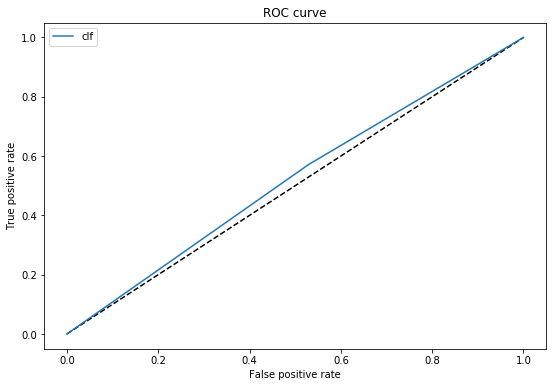

In [46]:
evaluate(X_test, y_test, rf)

### 4- Sample weights

#### 4.1- ¿Tiene sentido ponderar las observaciones?

Si, tiene sentido. Los eventos pueden tener una duración tal que genere concurrencia de los mismos. La concurrencia se la entiende como superposición de la duración de eventos consecutivos. Esto deriva en varios problemas, como ser:

- Duplicación de la información.
- Sobrestimación y sobreajuste en el modelo producto de la duplicación de la información.
- Los retornos excesivos contienen información importante, tal vez mayor que los retornos cercanos a la media.
- Los mercados son adaptativos, por lo que la información reciente es más relevante que la antigua. Por esta razón, es importante tener en cuenta el factor tiempo en la ponderación de la serie de eventos.
- Puede haber correlación cruzada entre distintas clases de eventos (por ejemplo: serie de precios vs. evolución de yield de bonos soberanos) a los que nos interese ponderar explícitamente en caso que ocurriera alguna anomalía (crisis repentina, guerras, etc.).

#### 4.2- ¿Cuáles ponderadores utilizaría? ¿Por uniqueness? ¿Por el tamaño del retorno?

En función de los motivos comentados anteriormente, se desprende que en el análisis cobra relevancia relevar por:

- Uniqueness: al poseer una ventana de barrera vertical tal que genere que los eventos puedan tener concurrencia, es importante ponderar que tanta unicidad tienen dichos eventos entre sí.
- Tamaño de retorno: retornos significativos respecto a alguna medida de volatilidad deben ser sobrepesados con el fin de resaltar la información del movimiento de precios que conllevan.
- Influencia cross-evento ya que es una serie que modela un mercado: con el fin de reducir el span de influencia de eventos uno con el otro, buscamos afectarlos temporalmente con el fin de disminuir la influencia de muestras pasadas.

#### 4.5- ¿Mejoran los resultados al ponderar?

In [47]:
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

def mpSampleTW(t1,numCoEvents,molecule):
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

def getIndMatrix(barIx,t1):
    # Get Indicator matrix
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

def getAvgUniqueness(indM):
    c=indM.sum(axis=1)
    u=indM.div(c, axis=0)
    avgU=u[u>0].mean()
    return avgU

def seqBootstrap(indM, sLength=None):
    if sLength is None: sLength = indM.shape[1]
    phi = []
    while len(phi) < sLength:
        avgU = pd.Series()
        for i in indM:
            indM_ = indM[phi+[i]]
            avgU.loc[i] = getAvgUniqueness(indM_).iloc[-1]
        prob = avgU / avgU.sum()
        phi += [np.random.choice(indM.columns, p=prob)]
    return phi

def getAvgUniqueness(indM):
    # Average uniqueness from indicator matrix
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

def seqBootstrap(indM,sLength=None):
    # Generate a sample via sequential bootstrap
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

def mpSampleW(t1, numCoEvents, close, molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

def getTimeDecay(tW,clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    return clfW

In [48]:
def evaluate(X,y,clf):
    from sklearn import metrics
    # The random forest model by itself
    y_pred_rf = clf.predict_proba(X)[:, 1]
    y_pred = clf.predict(X)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y, y_pred_rf)
    print(metrics.classification_report(y, y_pred))

    plt.figure(figsize=(9,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='clf')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    
def evaluate_multi(X_test, y_test, fit, n_classes=3):
    """
    adapted from:
        https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    from sklearn import metrics
    
    print(metrics.classification_report(y_test, fit.predict(X_test)))
    
    try:
        y_score = fit.decision_function(X_test)
    except:
        y_score = fit.predict_proba(X_test)
        
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(12,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    lw=2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Multiclass Bins')
    plt.legend(loc="lower right")
    plt.show()

In [49]:
# Obtains the crossing events of the 3-7 EWMA curves.
fast_ewma = compute_ewma(mtum_df.Close, FAST_EWMA_NUM_DAYS)
slow_ewma = compute_ewma(mtum_df.Close, SLOW_EWMA_NUM_DAYS)

up = get_up_cross(fast_ewma, slow_ewma)
down = get_down_cross(fast_ewma, slow_ewma)

side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()

In [50]:
# Gets the daily volatility of prices to serve events as a threshold.
dailyVol = getDailyVol(mtum_df.Close)
tEvents = getTEvents(mtum_df.Close, h=dailyVol.mean())
# Gets the vertical barrier events.
t1 = addVerticalBarrier(tEvents, mtum_df.Close, numDays=NUM_DAYS)
target=dailyVol
# Computes the events.
events = getEvents(mtum_df.Close, tEvents, PT_SL, target, MIN_RET, t1=t1, side=side)

# Gets the labels for the events.
labels = getBinsNew(events, mtum_df.Close, t1).dropna()
Xx = pd.merge_asof(labels, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')
Xx

/home/agustin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,ret,bin,side
54,0.012900,1.0,1
83,0.001508,1.0,-1
124,0.025018,1.0,1
194,0.013295,1.0,-1
206,0.014264,1.0,1
...,...,...,...
1614,-0.011292,0.0,-1
1620,0.006288,1.0,-1
1638,0.007695,1.0,-1
1640,-0.013713,0.0,-1


In [51]:
# Applies uniqueness, return weights and time decay to events.
numCoEvents = mpNumCoEvents(mtum_df.Close.index, events['t1'], events.index)
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(mtum_df.Close.index).fillna(0)

out=pd.DataFrame()
out['tW'] = mpSampleTW(events['t1'], numCoEvents, events.index)

out['w'] = mpSampleW(events['t1'], numCoEvents, mtum_df.Close, events.index)
out['w'] *= getTimeDecay(out['tW'], clfLastW=CLF_LAST_W)
out['w'] *= out.shape[0]/out['w'].sum()
averageUniqueness = out.mean()[0]

In [52]:
# Generates the Xs and Ys to learn the size.
# TODO: use the function!
X = events.dropna().side.values.reshape(-1,1)
y = labels.bin.values
y = label_binarize(y, classes=[-1,0,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

/home/agustin/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/agustin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/agustin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/agustin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.59      0.62      0.61        16
           2       0.60      0.56      0.58        16

   micro avg       0.59      0.59      0.59        32
   macro avg       0.40      0.40      0.40        32
weighted avg       0.59      0.59      0.59        32
 samples avg       0.59      0.59      0.59        32



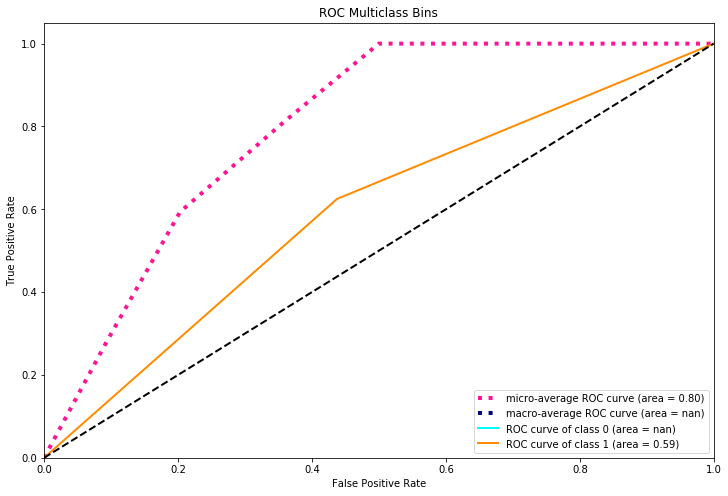

In [53]:
# Decision tree classifier + BaggingClassifier
base_clf = DecisionTreeClassifier(criterion='entropy',max_features='auto',
                                  class_weight='balanced')
bc = BaggingClassifier(base_estimator=base_clf,n_estimators=1000,
                       max_samples=averageUniqueness,max_features=1.,random_state=RANDOM_STATE)
clf = OneVsRestClassifier(bc)
fit = clf.fit(X_train,y_train)
evaluate_multi(X_test, y_test, fit, n_classes=len(np.unique(y)))

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=1,
                                class_weight='balanced_subsample',
                                criterion='entropy', 
                                bootstrap=False)
bc_rf = BaggingClassifier(base_estimator=rf_clf, n_estimators=1000,
                          max_samples=averageUniqueness, max_features=1., 
                          random_state=RANDOM_STATE)

clf2 = OneVsRestClassifier(bc_rf)
fit2 = clf2.fit(X_train,y_train)

evaluate_multi(X_test, y_test, fit2, n_classes=len(np.unique(y)))

/home/agustin/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/agustin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/agustin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.59      0.62      0.61        16
           2       0.60      0.56      0.58        16

   micro avg       0.59      0.59      0.59        32
   macro avg       0.40      0.40      0.40        32
weighted avg       0.59      0.59      0.59        32
 samples avg       0.59      0.59      0.59        32



/home/agustin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
